# **ЗАДАНИЕ №1: Анализ тональности и динамики конкурентов**
**Бизнес-идея: Сервис сравнения цен (e-grocery price monitor)**

**Конкуренты: Arbuz, Magnum, Carefood**

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# 1. НАСТРОЙКИ СТИЛЯ
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
# 2. ПОДГОТОВКА ДАННЫХ
def prepare_data():
    files = {'Arbuz': 'arbuz_reviews.csv', 'Magnum': 'magnum_reviews.csv', 'Carefood': 'carefood_reviews.csv'}
    dfs = []
    for company, path in files.items():
        temp = pd.read_csv(path)
        temp['company'] = company
        # Унификация колонок
        temp = temp.rename(columns={'text': 'review_text', 'review': 'review_text', 'score': 'rating'})
        dfs.append(temp)

    df = pd.concat(dfs, ignore_index=True)
    df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce').dt.tz_localize(None)
    df = df.dropna(subset=['review_text', 'review_date'])
    return df

df = prepare_data()

In [5]:
# 3. SENTIMENT ANALYSIS (RuBERT Base)
print("Загрузка модели RuBERT-Base...")
model_name = "blanchefort/rubert-base-cased-sentiment"
# Используем пайплайн для максимальной точности обработки текста
classifier = pipeline("sentiment-analysis", model=model_name, device=0 if torch.cuda.is_available() else -1)

def get_sentiment_batch(texts):
    results = []
    # Обрабатываем тексты, ограничивая длину для стабильности BERT
    for res in tqdm(classifier(texts, truncation=True, max_length=512), desc="Анализ тональности"):
        results.append(res['label'].lower())
    return results

df['sentiment'] = get_sentiment_batch(df['review_text'].tolist())

Загрузка модели RuBERT-Base...


Device set to use cpu


Анализ тональности:   0%|          | 0/403 [00:00<?, ?it/s]

In [6]:
# 4. ВАЛИДАЦИЯ (Accuracy Check)
def rating_to_sentiment(rating):
    if rating <= 2: return 'negative'
    elif rating == 3: return 'neutral'
    else: return 'positive'

df['true_sentiment'] = df['rating'].apply(rating_to_sentiment)

print("ОТЧЕТ ПО КАЧЕСТВУ")
print(classification_report(df['true_sentiment'], df['sentiment'], digits=3))

ОТЧЕТ ПО КАЧЕСТВУ
              precision    recall  f1-score   support

    negative      0.469     0.577     0.517        52
     neutral      0.302     0.569     0.395        51
    positive      0.938     0.760     0.840       300

    accuracy                          0.712       403
   macro avg      0.570     0.635     0.584       403
weighted avg      0.797     0.712     0.742       403



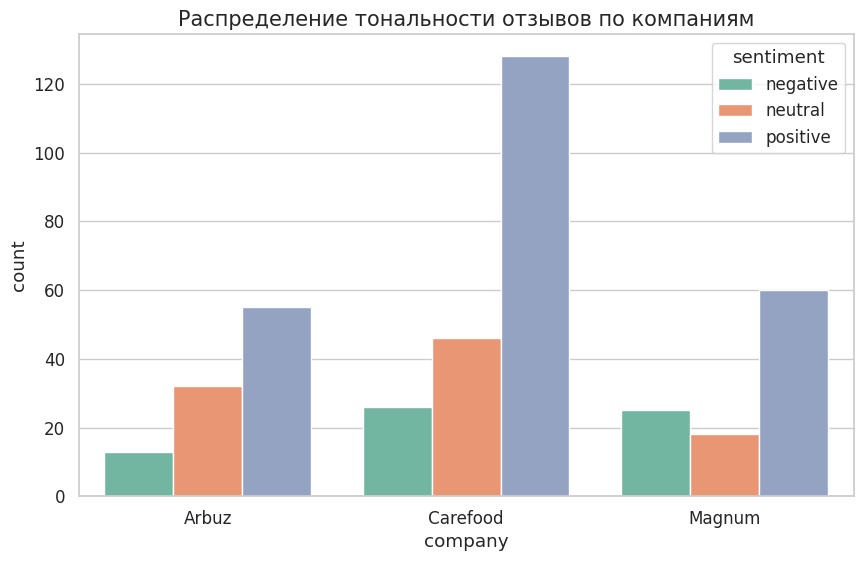

In [11]:
# 5. ПОСТРОЕНИЕ ГРАФИКОВ

# График 1: Распределение тональности
sentiment_dist = df.groupby(['company', 'sentiment']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_dist, x='company', y='count', hue='sentiment', palette='Set2')
plt.title('Распределение тональности отзывов по компаниям', fontsize=15)
plt.show()

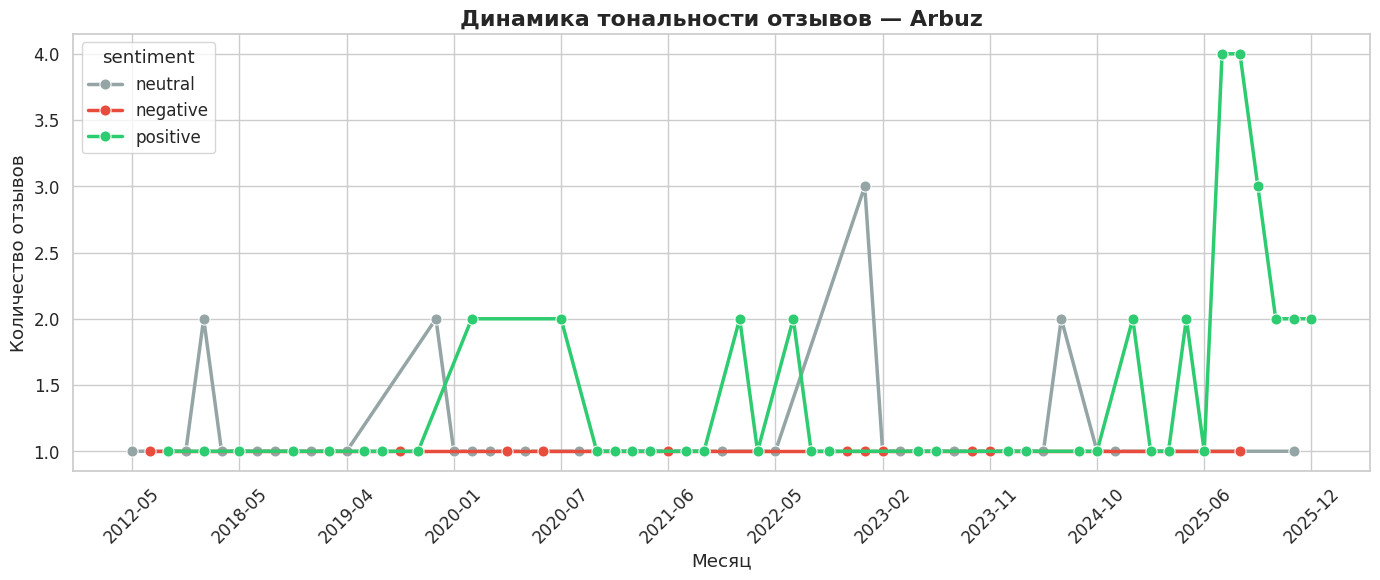

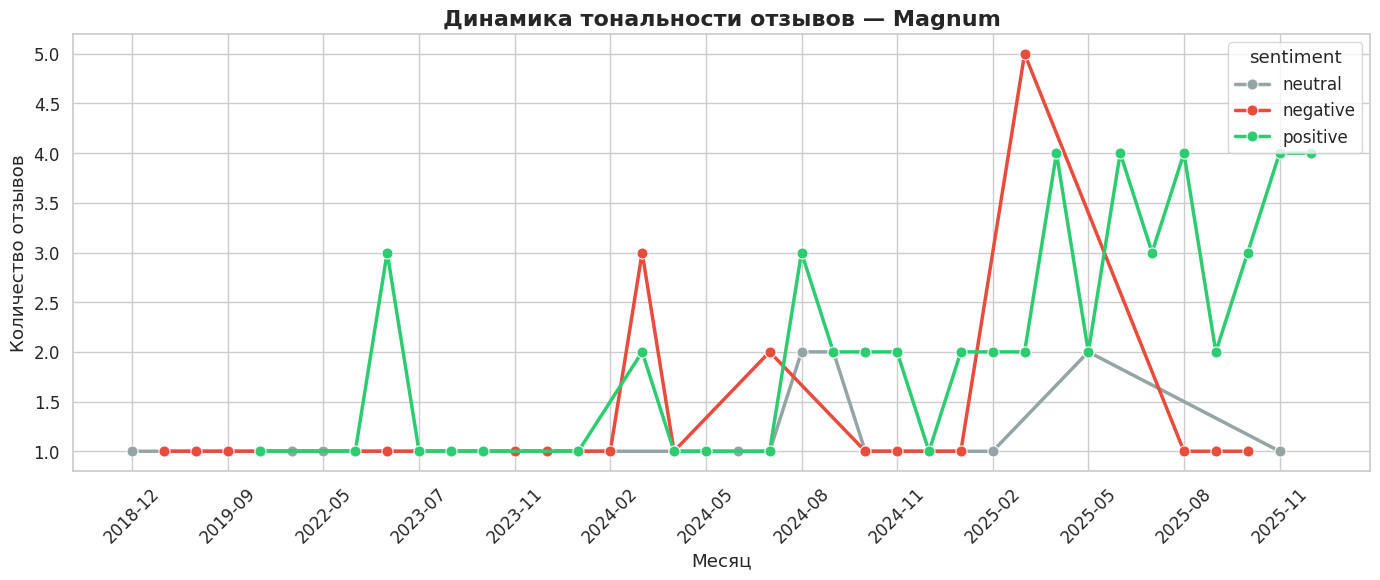

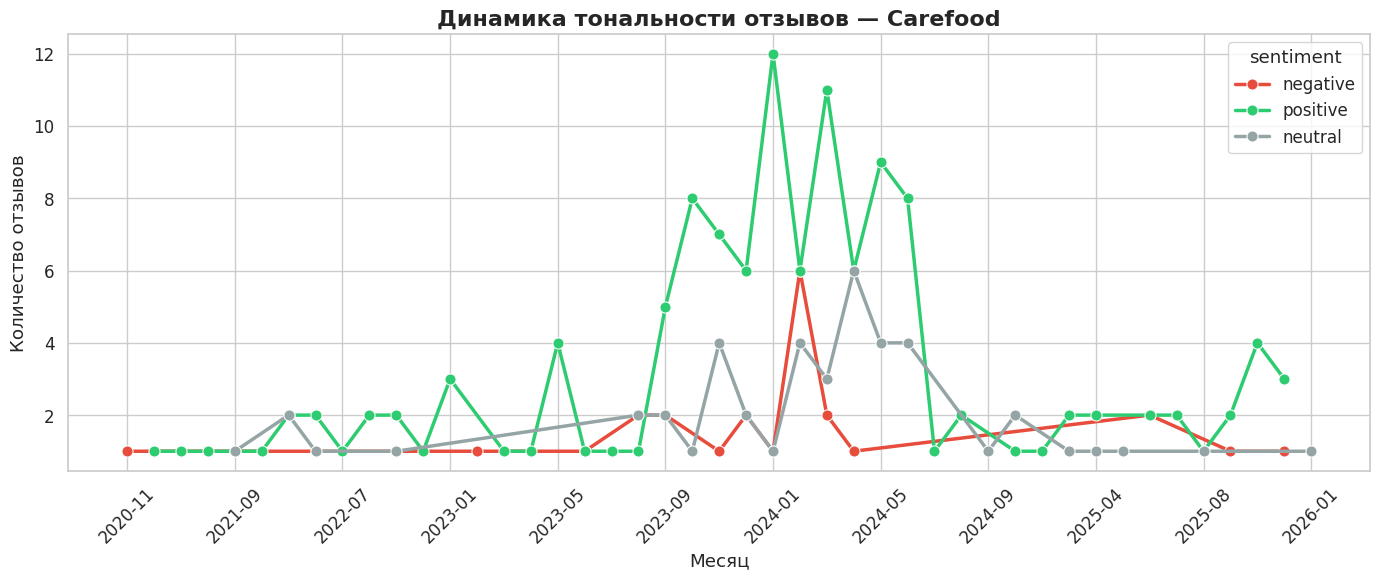

In [8]:
# График 2: Динамика по компаниям (Индивидуально)
df['month'] = df['review_date'].dt.to_period('M').astype(str)
sentiment_time = df.groupby(['month', 'company', 'sentiment']).size().reset_index(name='count')
sentiment_time = sentiment_time.sort_values('month')

palette_colors = {'positive': '#2ecc71', 'neutral': '#95a5a6', 'negative': '#e74c3c'}

for company in df['company'].unique():
    plt.figure(figsize=(14, 6))
    temp = sentiment_time[sentiment_time['company'] == company]

    sns.lineplot(
        data=temp, x='month', y='count', hue='sentiment',
        marker='o', markersize=8, linewidth=2.5, palette=palette_colors
    )

    # Оптимизация подписей дат
    ax = plt.gca()
    labels = temp['month'].unique()
    if len(labels) > 10:
        plt.xticks(np.arange(0, len(labels), step=max(1, len(labels)//10)), labels[::max(1, len(labels)//10)], rotation=45)
    else:
        plt.xticks(rotation=45)

    plt.title(f'Динамика тональности отзывов — {company}', fontsize=16, fontweight='bold')
    plt.ylabel('Количество отзывов')
    plt.xlabel('Месяц')
    plt.tight_layout()
    plt.show()

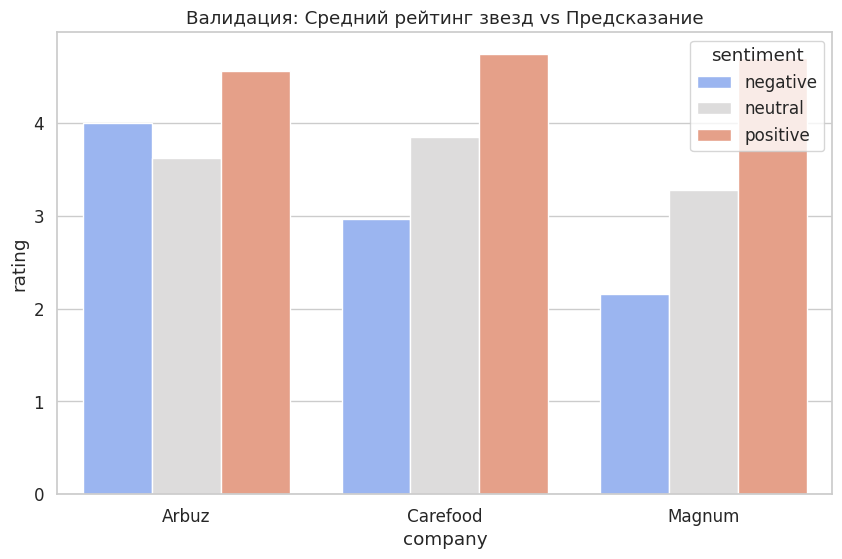

In [9]:
# График 3: Средний рейтинг (Проверка модели)
rating_sentiment = df.groupby(['company', 'sentiment'])['rating'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=rating_sentiment, x='company', y='rating', hue='sentiment', palette='coolwarm')
plt.title('Валидация: Средний рейтинг звезд vs Предсказание')
plt.show()

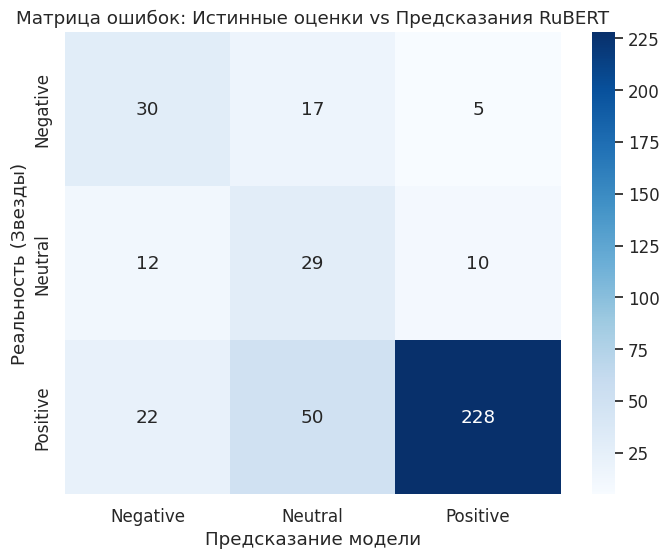

In [13]:
from sklearn.metrics import confusion_matrix

# Создаем матрицу ошибок
cm = confusion_matrix(df['true_sentiment'], df['sentiment'], labels=['negative', 'neutral', 'positive'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])

plt.title('Матрица ошибок: Истинные оценки vs Предсказания RuBERT')
plt.ylabel('Реальность (Звезды)')
plt.xlabel('Предсказание модели')
plt.show()

In [10]:
# Сохранение результата
df.to_csv('final_sentiment_results.csv', index=False)